## LLAVA on SageMaker

- LLAVA 모델을 sagemaker에서 async endpoint로 테스트 진행
- DeepSpeed나 FasterTransformer 를 사용하고 있지는 않지만, DJL을 활용하도록 함.
- S3에 모델 업로드 -> 코드 수정 -> 코드 s3에 업로드 -> SageMaker endpoint 생성 -> 확인


In [3]:
%store -r

In [4]:
model_artifact

's3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/model'

In [5]:
import boto3
import sagemaker
from sagemaker.utils import name_from_base
from sagemaker import image_uris

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [44]:
!pip uninstall tokenizers --yes
!pip install tokenizers==0.13.0
!pip install -e '.[dev]'

Found existing installation: tokenizers 0.15.1
Uninstalling tokenizers-0.15.1:
  Successfully uninstalled tokenizers-0.15.1
  Using cached tokenizers-0.13.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (7.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llava 1.1.1 requires transformers==4.31.0, but you have transformers 4.37.1 which is incompatible.
transformers 4.37.1 requires tokenizers<0.19,>=0.14, but you have tokenizers 0.13.0 which is incompatible.
Obtaining file:///root/gen-ai-sagemaker/MultiModal
ERROR: file:///root/gen-ai-sagemaker/MultiModal does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [7]:
llm_engine = "deepspeed"
# llm_engine = "fastertransformer"

In [8]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
sm_client = sagemaker_session.sagemaker_client
sm_runtime_client = sagemaker_session.sagemaker_runtime_client
s3_client = boto3.client('s3')
default_bucket = sagemaker_session.default_bucket()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [9]:
framework_name = f"djl-{llm_engine}"
inference_image_uri = image_uris.retrieve(
    framework=framework_name, region=sagemaker_session.boto_session.region_name, version="0.23.0"
)

print(f"Inference container uri: {inference_image_uri}")

Inference container uri: 763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.23.0-deepspeed0.9.5-cu118


In [10]:
s3_target = f"s3://{sagemaker_session.default_bucket()}/llm/llava/llava-v15/code/"
print(s3_target)

s3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/code/


In [11]:
!rm llava-src.tar.gz
!tar zcvf llava-src.tar.gz llava-src --exclude ".ipynb_checkpoints" --exclude "__pycache__"
!aws s3 cp llava-src.tar.gz {s3_target}

rm: cannot remove 'llava-src.tar.gz': No such file or directory
llava-src/
llava-src/model.py
llava-src/requirements.txt
llava-src/.ipynb_checkpoints/
llava-src/.ipynb_checkpoints/serving-checkpoint.properties
llava-src/serving.properties
llava-src/run_llava_local.py
tar: The following options were used after any non-optional arguments in archive create or update mode.  These options are positional and affect only arguments that follow them.  Please, rearrange them properly.
tar: --exclude ‘.ipynb_checkpoints’ has no effect
tar: --exclude ‘__pycache__’ has no effect
tar: Exiting with failure status due to previous errors
upload: ./llava-src.tar.gz to s3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/code/llava-src.tar.gz


In [12]:
model_uri = f"{s3_target}llava-src.tar.gz"
print(model_uri)

s3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/code/llava-src.tar.gz


### SageMaker endpoint 활용한 배포

- Async Endpoint로 배포를 진행함.

In [13]:
model_name = name_from_base(f"llava-djl")
print(model_name)

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={"Image": inference_image_uri, "ModelDataUrl": model_uri},
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

llava-djl-2024-01-25-14-45-29-486
Created Model: arn:aws:sagemaker:us-east-1:988564344122:model/llava-djl-2024-01-25-14-45-29-486


In [14]:
default_bucket = sagemaker_session.default_bucket()
async_output_uri = f"s3://{default_bucket}/llm/outputs/{model_name}/"
print(async_output_uri)

s3://sagemaker-us-east-1-988564344122/llm/outputs/llava-djl-2024-01-25-14-45-29-486/


In [15]:
instance_type = "ml.g5.2xlarge"
# instance_type = "ml.g5.xlarge"
# instance_type = "ml.g4dn.xlarge"

endpoint_config_name = f"{model_name}-async-config"
endpoint_name = f"{model_name}-async-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "ContainerStartupHealthCheckTimeoutInSeconds": 600,
        },
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": async_output_uri,
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": 1
        }
    }
)
print(endpoint_config_response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:988564344122:endpoint-config/llava-djl-2024-01-25-14-45-29-486-async-config', 'ResponseMetadata': {'RequestId': '6a083f94-b66c-4532-a447-d6146d77695d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '6a083f94-b66c-4532-a447-d6146d77695d', 'content-type': 'application/x-amz-json-1.1', 'content-length': '127', 'date': 'Thu, 25 Jan 2024 14:45:31 GMT'}, 'RetryAttempts': 0}}


In [16]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

Created Endpoint: arn:aws:sagemaker:us-east-1:988564344122:endpoint/llava-djl-2024-01-25-14-45-29-486-async-endpoint


In [17]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:988564344122:endpoint/llava-djl-2024-01-25-14-45-29-486-async-endpoint
Status: InService


In [18]:
import json
import uuid

In [25]:
prompt = "where is the 25 exist in the matrix table?"

In [26]:
payload = {
    "text": [prompt],
    "input_image_s3": "s3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/input_samples/test_01.jpg",
}

In [29]:
# Upload input data onto the S3
s3_uri = f"llm/inputs/{model_name}/{uuid.uuid4()}.json"
print (f" the s3 uri --> {s3_uri}")
s3_client.put_object(
    Bucket=default_bucket,
    Key=s3_uri,
    Body=json.dumps(payload))

input_data_uri = f"s3://{default_bucket}/{s3_uri}"
print (f"input data uri --> {input_data_uri}")
input_location = input_data_uri

 the s3 uri --> llm/inputs/llava-djl-2024-01-25-14-45-29-486/335e109d-4e4f-40f2-b2bb-ec4b3e558f0f.json
input data uri --> s3://sagemaker-us-east-1-988564344122/llm/inputs/llava-djl-2024-01-25-14-45-29-486/335e109d-4e4f-40f2-b2bb-ec4b3e558f0f.json


In [30]:
response = sm_runtime_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_location,
    ContentType="application/json"
)
output_location = response["OutputLocation"]
print(output_location)
output_key_uri = "/".join(output_location.split("/")[3:])

s3://sagemaker-us-east-1-988564344122/llm/outputs/llava-djl-2024-01-25-14-45-29-486/d490e2ad-a343-4261-9e06-484a727d3a3d.out


In [33]:
try:
    exists = s3_client.head_object(Bucket=default_bucket, Key=output_key_uri)['ResponseMetadata']['HTTPStatusCode'] == 200
    if exists:
        text_obj = s3_client.get_object(Bucket=default_bucket, Key=output_key_uri)['Body'].read()
        text = text_obj.decode('utf-8')
        print(text)
except:
    print("Data is not exist yet. Wait until inference finished or check the CW log")

The 25 exists in the matrix table in the middle row, second column.</s>


In [34]:
output = text.split("</s>")[0]
print(output)

The 25 exists in the matrix table in the middle row, second column.


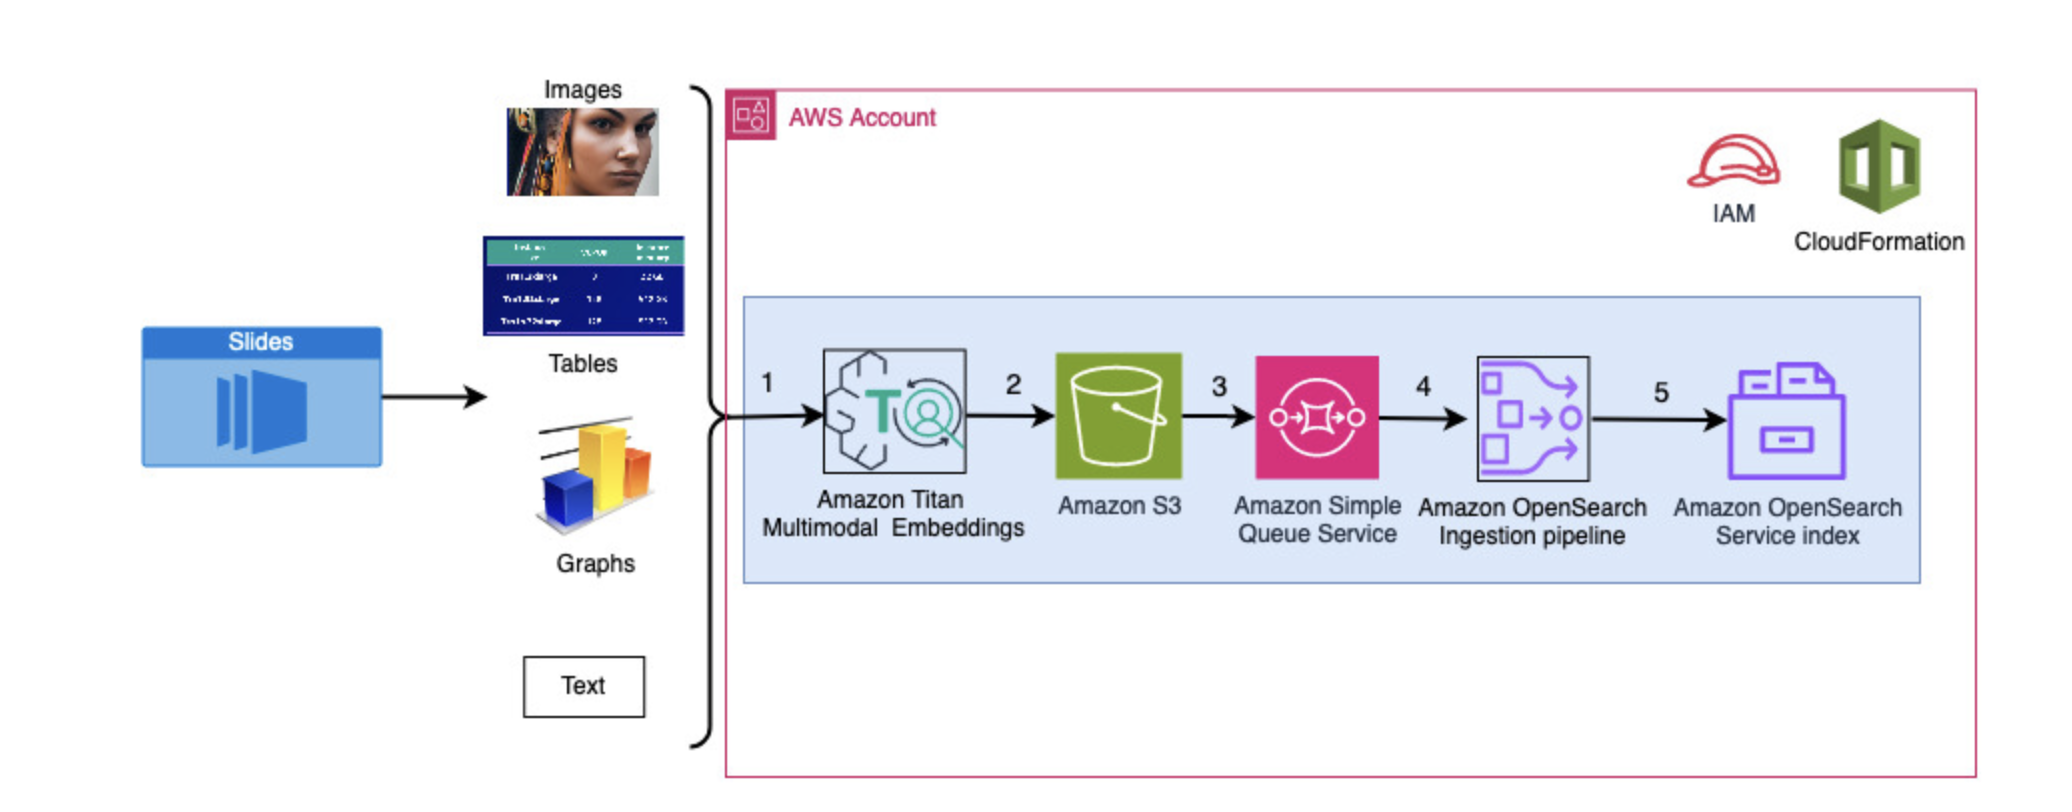

In [52]:
import boto3
from IPython.display import display, Image
from io import BytesIO

# Specify the S3 bucket and object key
bucket_name = 'sagemaker-us-east-1-988564344122'
object_key = 'llm/llava/llava-v15/input_samples/1.jpg'

# Retrieve the image from S3
obj = s3_client.get_object(Bucket=bucket_name, Key=object_key)
image_data = obj['Body'].read()

# Display the image
display(Image(data=image_data))

In [55]:
prompt = "What do you see in the aws account architecture in the image?"

payload = {
    "text": [prompt],
    "input_image_s3": "s3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/input_samples/1.jpg",
}

# Upload input data onto the S3
s3_uri = f"llm/inputs/{model_name}/{uuid.uuid4()}.json"
print (f" the s3 uri --> {s3_uri}")
s3_client.put_object(
    Bucket=default_bucket,
    Key=s3_uri,
    Body=json.dumps(payload))

input_data_uri = f"s3://{default_bucket}/{s3_uri}"
print (f"input data uri --> {input_data_uri}")
input_location = input_data_uri

response = sm_runtime_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_location,
    ContentType="application/json"
)
output_location = response["OutputLocation"]
print(output_location)
output_key_uri = "/".join(output_location.split("/")[3:])

 the s3 uri --> llm/inputs/llava-djl-2024-01-25-14-45-29-486/28283b33-9026-4e46-bcea-820971cd63a5.json
input data uri --> s3://sagemaker-us-east-1-988564344122/llm/inputs/llava-djl-2024-01-25-14-45-29-486/28283b33-9026-4e46-bcea-820971cd63a5.json
s3://sagemaker-us-east-1-988564344122/llm/outputs/llava-djl-2024-01-25-14-45-29-486/698161fb-972b-433c-bada-d18768ccf0ac.out


In [57]:
try:
    exists = s3_client.head_object(Bucket=default_bucket, Key=output_key_uri)['ResponseMetadata']['HTTPStatusCode'] == 200
    if exists:
        text_obj = s3_client.get_object(Bucket=default_bucket, Key=output_key_uri)['Body'].read()
        text = text_obj.decode('utf-8')
        print(text)
except:
    print("Data is not exist yet. Wait until inference finished or check the CW log")

The image shows an architecture of an AWS account, which includes various components such as Amazon S3, Amazon Titan, and Amazon Simple Queue Service (SQS). These components are connected by arrows, indicating their relationships and interactions within the AWS account.</s>


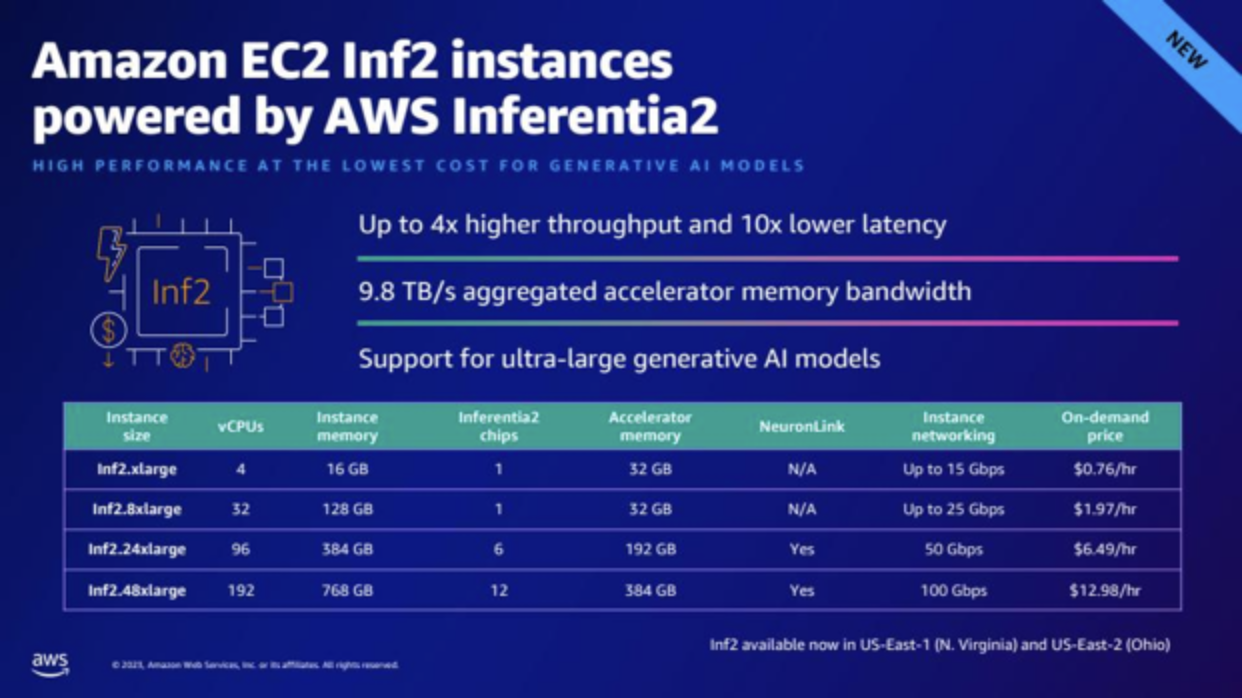

In [58]:
import boto3
from IPython.display import display, Image
from io import BytesIO

# Specify the S3 bucket and object key
bucket_name = 'sagemaker-us-east-1-988564344122'
object_key = 'llm/llava/llava-v15/input_samples/2.jpg'

# Retrieve the image from S3
obj = s3_client.get_object(Bucket=bucket_name, Key=object_key)
image_data = obj['Body'].read()

# Display the image
display(Image(data=image_data))

In [68]:
prompt = "What are the vCPUs you see on the screen for EC2 Inf2 instances powered by AWS Inferentia2?"

payload = {
    "text": [prompt],
    "input_image_s3": "s3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/input_samples/2.jpg",
}

# Upload input data onto the S3
s3_uri = f"llm/inputs/{model_name}/{uuid.uuid4()}.json"
print (f" the s3 uri --> {s3_uri}")
s3_client.put_object(
    Bucket=default_bucket,
    Key=s3_uri,
    Body=json.dumps(payload))

input_data_uri = f"s3://{default_bucket}/{s3_uri}"
print (f"input data uri --> {input_data_uri}")
input_location = input_data_uri

response = sm_runtime_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_location,
    ContentType="application/json"
)
output_location = response["OutputLocation"]
print(output_location)
output_key_uri = "/".join(output_location.split("/")[3:])

 the s3 uri --> llm/inputs/llava-djl-2024-01-25-14-45-29-486/97c6307e-db04-4121-9edd-0574bdd6369a.json
input data uri --> s3://sagemaker-us-east-1-988564344122/llm/inputs/llava-djl-2024-01-25-14-45-29-486/97c6307e-db04-4121-9edd-0574bdd6369a.json
s3://sagemaker-us-east-1-988564344122/llm/outputs/llava-djl-2024-01-25-14-45-29-486/07cd8b5c-a446-4599-bfde-f0f585752aaa.out


In [77]:
try:
    exists = s3_client.head_object(Bucket=default_bucket, Key=output_key_uri)['ResponseMetadata']['HTTPStatusCode'] == 200
    if exists:
        text_obj = s3_client.get_object(Bucket=default_bucket, Key=output_key_uri)['Body'].read()
        text = text_obj.decode('utf-8')
        print(text)
except:
    print("Data is not exist yet. Wait until inference finished or check the CW log")

The vCPUs displayed on the screen for EC2 Inf2 instances powered by AWS Inferentia2 are 2, 4, 8, 16, 32, and 64.</s>


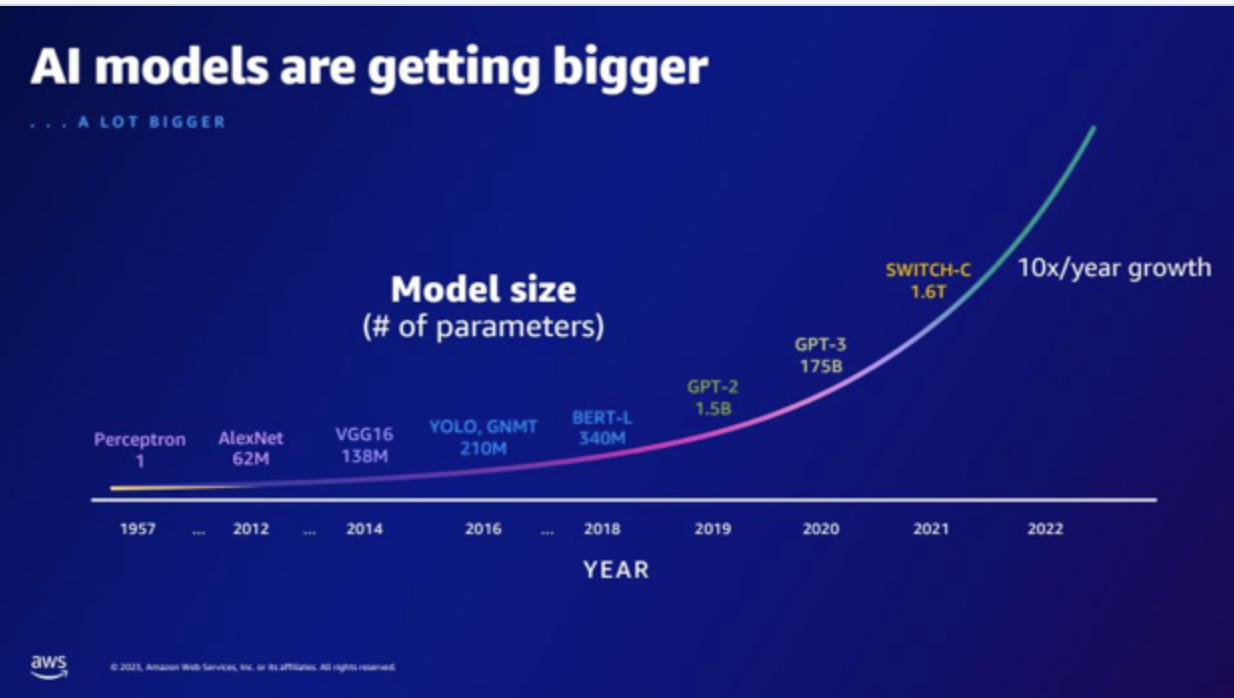

In [140]:
import boto3
from IPython.display import display, Image
from io import BytesIO

# Specify the S3 bucket and object key
bucket_name = 'sagemaker-us-east-1-988564344122'
object_key = 'llm/llava/llava-v15/input_samples/3.jpg'

# Retrieve the image from S3
obj = s3_client.get_object(Bucket=bucket_name, Key=object_key)
image_data = obj['Body'].read()

# Display the image
display(Image(data=image_data))

In [141]:
prompt = "Give me the names of models as the model size increases across the years and their corresponding number of parameters?"

payload = {
    "text": [prompt],
    "input_image_s3": "s3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/input_samples/3.jpg",
}

# Upload input data onto the S3
s3_uri = f"llm/inputs/{model_name}/{uuid.uuid4()}.json"
print (f" the s3 uri --> {s3_uri}")
s3_client.put_object(
    Bucket=default_bucket,
    Key=s3_uri,
    Body=json.dumps(payload))

input_data_uri = f"s3://{default_bucket}/{s3_uri}"
print (f"input data uri --> {input_data_uri}")
input_location = input_data_uri

response = sm_runtime_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_location,
    ContentType="application/json"
)
output_location = response["OutputLocation"]
print(output_location)
output_key_uri = "/".join(output_location.split("/")[3:])

 the s3 uri --> llm/inputs/llava-djl-2024-01-25-14-45-29-486/050012bb-2ad4-46bc-afe7-012f05cc087c.json
input data uri --> s3://sagemaker-us-east-1-988564344122/llm/inputs/llava-djl-2024-01-25-14-45-29-486/050012bb-2ad4-46bc-afe7-012f05cc087c.json
s3://sagemaker-us-east-1-988564344122/llm/outputs/llava-djl-2024-01-25-14-45-29-486/32be0c04-5f38-4d87-af47-873edd1a4f29.out


In [138]:
try:
    exists = s3_client.head_object(Bucket=default_bucket, Key=output_key_uri)['ResponseMetadata']['HTTPStatusCode'] == 200
    if exists:
        text_obj = s3_client.get_object(Bucket=default_bucket, Key=output_key_uri)['Body'].read()
        text = text_obj.decode('utf-8')
        print(text)
except:
    print("Data is not exist yet. Wait until inference finished or check the CW log")

Data is not exist yet. Wait until inference finished or check the CW log


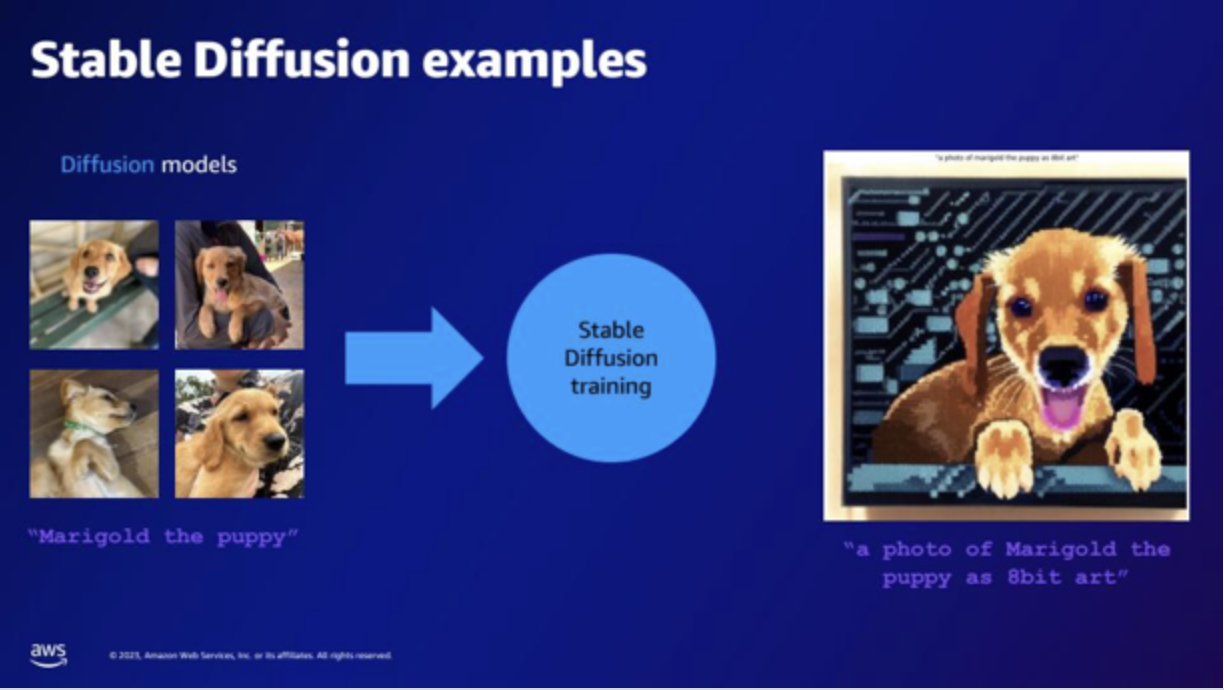

In [124]:
import boto3
from IPython.display import display, Image
from io import BytesIO

# Specify the S3 bucket and object key
bucket_name = 'sagemaker-us-east-1-988564344122'
object_key = 'llm/llava/llava-v15/input_samples/4.jpg'

# Retrieve the image from S3
obj = s3_client.get_object(Bucket=bucket_name, Key=object_key)
image_data = obj['Body'].read()

# Display the image
display(Image(data=image_data))

In [125]:
prompt = "Give me a detailed description of every single thing on the image"

payload = {
    "text": [prompt],
    "input_image_s3": "s3://sagemaker-us-east-1-988564344122/llm/llava/llava-v15/input_samples/4.jpg",
}

# Upload input data onto the S3
s3_uri = f"llm/inputs/{model_name}/{uuid.uuid4()}.json"
print (f" the s3 uri --> {s3_uri}")
s3_client.put_object(
    Bucket=default_bucket,
    Key=s3_uri,
    Body=json.dumps(payload))

input_data_uri = f"s3://{default_bucket}/{s3_uri}"
print (f"input data uri --> {input_data_uri}")
input_location = input_data_uri

response = sm_runtime_client.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_location,
    ContentType="application/json"
)
output_location = response["OutputLocation"]
print(output_location)
output_key_uri = "/".join(output_location.split("/")[3:])

 the s3 uri --> llm/inputs/llava-djl-2024-01-25-14-45-29-486/a425c299-6be6-4fc6-8923-11553a2bb5f7.json
input data uri --> s3://sagemaker-us-east-1-988564344122/llm/inputs/llava-djl-2024-01-25-14-45-29-486/a425c299-6be6-4fc6-8923-11553a2bb5f7.json
s3://sagemaker-us-east-1-988564344122/llm/outputs/llava-djl-2024-01-25-14-45-29-486/7fd4a21e-08ce-465f-8e38-753fa8c58122.out


In [139]:
try:
    exists = s3_client.head_object(Bucket=default_bucket, Key=output_key_uri)['ResponseMetadata']['HTTPStatusCode'] == 200
    if exists:
        text_obj = s3_client.get_object(Bucket=default_bucket, Key=output_key_uri)['Body'].read()
        text = text_obj.decode('utf-8')
        print(text)
except:
    print("Data is not exist yet. Wait until inference finished or check the CW log")

Data is not exist yet. Wait until inference finished or check the CW log
